## HydroTrend

* Link to this notebook: https://github.com/csdms/pymt/blob/master/docs/demos/hydrotrend.ipynb
* Install command: `$ conda install notebook pymt_hydrotrend`

HydroTrend is a 2D hydrological water balance and transport model that simulates water discharge and sediment load at a river outlet. You can read more about the model, find references or download the source code at: https://csdms.colorado.edu/wiki/Model:HydroTrend.

### River Sediment Supply Modeling

This notebook is meant to give you a better understanding of what the model is capable of. In this example we are using a theoretical river basin of ~1990 km<sup>2</sup>, with 1200m of relief and a river length of
~100 km. All parameters that are shown by default once the HydroTrend Model is loaded are based
on a present-day, temperate climate. Whereas these runs are not meant to be specific, we are
using parameters that are realistic for the [Waiapaoa River][map_of_waiapaoa] in New Zealand. The Waiapaoa River
is located on North Island and receives high rain and has erodible soils, so the river sediment
loads are exceptionally high. It has been called the *"dirtiest small river in the world"*.

To learn more about HydroTrend and its approach to sediment supply modeling, you can download
this [presentation][hydrotrend_presentation].

A more detailed description of applying HydroTrend to the Waipaoa basin, New Zealand has been published in WRR: [hydrotrend_waipaoa_paper]. 

[map_of_waiapaoa]: https://www.google.com/maps/place/Waipaoa+River/@-38.5099042,177.7668002,71814m/data=!3m1!1e3!4m5!3m4!1s0x6d65def908624859:0x2a00ef6165e1dfa0!8m2!3d-38.5392405!4d177.8843782
[hydrotrend_presentation]: https://csdms.colorado.edu/wiki/File:SedimentSupplyModeling02_2013.ppt
[hydrotrend_waipaoa_paper]: http://dx.doi.org/10.1029/2006WR005570

### Exercise
To start, import numpy, matplotlib, and PyMT.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pymt

✓ Avulsion
✓ Plume
✓ Sedflux3D
✓ Subside
✓ FrostNumber
✓ Ku
✓ Hydrotrend
✓ Child
✓ Cem
✓ Waves


And load the HydroTrend plugin.


In [2]:
hydrotrend = pymt.plugins.Hydrotrend()

HydroTrend will now be activated in PyMT.


### Exercise 1: Explore the base-case river simulation

The default "base-case" simulation for 50 years at daily time-step. This means you run Hydrotrend for 18,250 days total. 

In [3]:
config_file, config_folder = hydrotrend.setup()

In [4]:
hydrotrend.initialize(config_file, config_folder)

In [5]:
hydrotrend.output_var_names

('atmosphere_bottom_air__domain_mean_of_temperature',
 'channel_exit_water_sediment~suspended__mass_flow_rate',
 'channel_exit_water_flow__speed',
 'channel_entrance_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water__volume_flow_rate',
 'channel_exit_water_x-section__width',
 'channel_exit_water_x-section__depth',
 'channel_entrance_water__volume_flow_rate',
 'atmosphere_water__domain_mean_of_precipitation_leq-volume_flux',
 'channel_exit_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water_sediment~suspended__mass_concentration')

In [6]:
hydrotrend.get_start_time(), hydrotrend.get_current_time(), hydrotrend.get_end_time(), hydrotrend.get_time_step(), hydrotrend.get_time_units()

(0.0, 0.0, 36500.0, 1.0, 'd')

In [7]:
n_days = int(hydrotrend.get_end_time())
q = np.empty(n_days)
qs = np.empty(n_days)
cs = np.empty(n_days)
qb = np.empty(n_days)
for i in range(n_days):
    hydrotrend.update()
    q[i] = hydrotrend.get_value("channel_exit_water__volume_flow_rate")
    qs[i] = hydrotrend.get_value("channel_exit_water_sediment~suspended__mass_flow_rate")
    cs[i] = hydrotrend.get_value("channel_exit_water_sediment~suspended__mass_concentration")
    qb[i] = hydrotrend.get_value("channel_exit_water_sediment~bedload__mass_flow_rate")

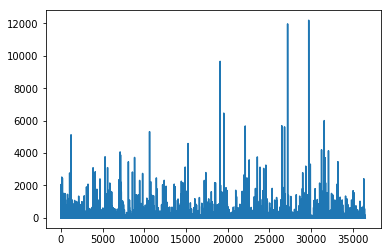

In [8]:
plt.plot(qs)

#### Q1a: Calculate mean water discharge Q, mean suspended load Qs, mean sediment concentration Cs, and mean bedload Qb.

*Note all values are reported as daily averages. What are the units?*

*A1a*:

In [9]:
(
    (q.mean(), hydrotrend.get_var_units("channel_exit_water__volume_flow_rate")),
    (cs.mean(), hydrotrend.get_var_units("channel_exit_water_sediment~suspended__mass_flow_rate")),
    (qs.mean(), hydrotrend.get_var_units("channel_exit_water_sediment~suspended__mass_concentration")),
    (qb.mean(), hydrotrend.get_var_units("channel_exit_water_sediment~bedload__mass_flow_rate"))
)

((78.860528085872986, 'm^3 / s'),
 (0.17000387392377275, 'kg / s'),
 (32.013717040644423, 'kg / m^3'),
 (2.0013798085652184, 'kg / s'))

In [10]:
hydrotrend.get_var_units("channel_exit_water__volume_flow_rate")

'm^3 / s'

#### Q1b: Identify the highest flood event for this simulation. Is this the 50-year flood? Plot the year of Q-data which includes the flood.

*A1b*:

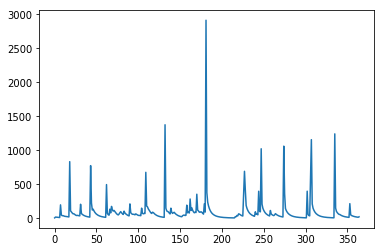

In [11]:
flood_day = q.argmax()
flood_year = flood_day // 365
plt.plot(q[flood_year * 365: (flood_year + 1) * 365])

In [12]:
q.max()

2911.8655468780021

#### Q1c: Calculate the mean annual sediment load for this river system.

*A1c*:

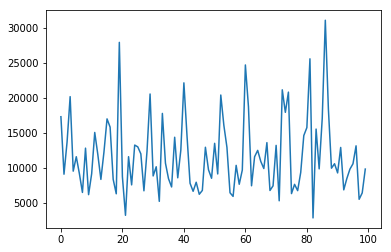

In [13]:
qs_by_year = qs.reshape((-1, 365))
qs_annual = qs_by_year.sum(axis=1)
plt.plot(qs_annual)

In [14]:
qs_annual.mean()

11685.006719835217

#### Q1d: How does the sediment yield of this river system compare to the present-day Mississippi River?

*To compare the mean annual load to other river systems you will need to calculate its sediment yield. 
Sediment Yield is defined as sediment load normalized for the river drainage area; 
so it can be reported in T/km2/yr.*

*A1d*:

### Exercise 2: How does a river system respond to climate change; a few simple scenarios for the coming century.

Now we will look at changing climatic conditions in a small river basin. We'll change temperature and precipitation regimes and compare discharge and sediment load characteristics to the original basecase. And we will look at the are potential implications of changes in the peak events.

Modify the mean annual temperature T, the mean annual precipitation P, and its the variability of the yearly means through the standard deviation. You can specify trends over time, by modifying the parameter ‘change in mean annual temperature’ or ‘change in mean annual precipitation’. HydroTrend runs at daily timestep, and thus can deal with seasonal variations in temperature and precipitation for a basin. The model ingests monthly mean input values for these two climate parameters and their monthly standard deviations, ideally the values would be derived from analysis of a longterm record of daily climate data. You can adapt seasonal trends by using the monthly values.

#### Q2a: What happens to discharge, suspended load and bedload if the mean annual temperature in this specific river basin increases by 4 °C over 50 years?

*A2a*:

#### Q2b: How much increase of discharge do you see after 50 years? How is the average suspended load affected? How does the bedload change? What happens to the peak event; look at the maximum discharge event of the last 10 years of the simulation?

*A2b*:

#### Q2c: In addition, climate model predictions indicate that perhaps precipitation intensity and variability could increase. How would you model this; discuss all your input settings for precipitation.

*A2c*:

### Exercise 3: How do humans affect river sediment loads?

Here we will look at the effect of human in a river basin. Humans can accelerate erosion
processes, or reduce the sediment loads traveling through a river system. Both concepts can
be simulated, first run 3 simulations systematically increasing the anthropogenic factor (0.5-8.0 is the range).

#### Q3a: Describe in your own words the meaning of the human-induced erosion factor, (Eh) (Syvitski & Milliman, 2007). This factor is parametrized as the  “Antropogenic” factor in HydroTrend. See references for the paper.

*A3a*:

Model a scenario of a drinking water supply reservoir to be planned in the coastal area of the basin. The reservoir would have 800 km 2of contributing drainage area and be 3 km long, 200m wide and 100m deep. Set up a simulation with these parameters.

#### Q3b: How would such a reservoir affect the sediment load at the coast (i.e. downstream of the reservoir)?

*A3b*: